In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import tensorflow as tf
import keras
import keras.backend as K

import scipy

from keras.models import load_model

import matplotlib
matplotlib.rc('pdf', fonttype=42)
matplotlib.rc("ps", fonttype=42)

%matplotlib inline

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

from keras.callbacks import Callback

from scipy.signal import gaussian

class SequenceEncoder :
    
    def __init__(self, encoder_type_id, encode_dims) :
        self.encoder_type_id = encoder_type_id
        self.encode_dims = encode_dims
    
    def encode(self, seq) :
        raise NotImplementedError()
    
    def encode_inplace(self, seq, encoding) :
        raise NotImplementedError()
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementedError()
    
    def decode(self, encoding) :
        raise NotImplementedError()
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementedError()
    
    def __call__(self, seq) :
        return self.encode(seq)
    
class OneHotEncoder(SequenceEncoder) :
    
    def __init__(self, seq_length, channel_map) :
        super(OneHotEncoder, self).__init__('onehot', (seq_length, len(channel_map)))
        
        self.seq_len = seq_length
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += self.decode_map[self.n_channels - 1]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)


2023-05-08 17:21:39.926290: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


Using TensorFlow backend.
2023-05-08 17:21:41.183041: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2023-05-08 17:21:41.184696: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d7c8ce4a20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-05-08 17:21:41.184725: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-05-08 17:21:41.187041: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-05-08 17:21:41.343947: E tensorflow/stream_executor/cuda/cuda_driver.cc:322] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-08 17:21:41.344007: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (johannes-design-interpret-1): /proc/driver/nvidia/version does not exist


In [2]:
#Load APARENT2 model

import os

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, LocallyConnected2D, Conv1D, MaxPooling1D, LocallyConnected1D, LSTM, ConvLSTM2D, BatchNormalization
from keras.layers import Concatenate, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf

def make_resblock(n_channels=64, window_size=8, dilation_rate=1, group_ix=0, layer_ix=0, drop_rate=0.0) :

    #Initialize res block layers
    batch_norm_0 = BatchNormalization(name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_0 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    batch_norm_1 = BatchNormalization(name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_1 = Lambda(lambda x: x[0] + x[1], name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    drop_1 = None
    if drop_rate > 0.0 :
        drop_1 = Dropout(drop_rate)
    
    #Execute res block
    def _resblock_func(input_tensor) :
        batch_norm_0_out = batch_norm_0(input_tensor, training=False)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out, training=False)
        relu_1_out = relu_1(batch_norm_1_out)
        
        if drop_rate > 0.0 :
            conv_1_out = drop_1(conv_1(relu_1_out))
        else :
            conv_1_out = conv_1(relu_1_out)

        skip_1_out = skip_1([conv_1_out, input_tensor])
        
        return skip_1_out

    return _resblock_func

def load_residual_network(n_groups=1, n_resblocks_per_group=4, n_channels=32, window_size=8, dilation_rates=[1], drop_rate=0.0) :

    #Discriminator network definition
    conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_conv_0')
    
    skip_convs = []
    resblock_groups = []
    for group_ix in range(n_groups) :
        
        skip_convs.append(Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_skip_conv_' + str(group_ix)))
        
        resblocks = []
        for layer_ix in range(n_resblocks_per_group) :
            resblocks.append(make_resblock(n_channels=n_channels, window_size=window_size, dilation_rate=dilation_rates[group_ix], group_ix=group_ix, layer_ix=layer_ix, drop_rate=drop_rate))
        
        resblock_groups.append(resblocks)

    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1], name='aparent_skip_add')
    
    final_conv = Conv2D(1, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_final_conv')
    
    extend_tensor = Lambda(lambda x: K.concatenate([x[0], x[1][..., None, None]], axis=2), name='aparent_extend_tensor')
    
    expand_lib = Lambda(lambda x: K.tile(K.expand_dims(K.expand_dims(x, axis=1), axis=2), (1, 1, 206, 1)), name='aparent_expand_lib')
    
    lib_conv = LocallyConnected2D(1, (1, 1), strides=(1, 1), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='aparent_lib_conv')
    
    lib_add = Lambda(lambda x: x[0] + x[1], name='aparent_lib_add')
    
    def _net_func(sequence_input, lib_input, dummy_input) :
        conv_0_out = conv_0(sequence_input)

        #Connect group of res blocks
        output_tensor = conv_0_out

        #Res block group execution
        skip_conv_outs = []
        for group_ix in range(n_groups) :
            skip_conv_out = skip_convs[group_ix](output_tensor)
            skip_conv_outs.append(skip_conv_out)

            for layer_ix in range(n_resblocks_per_group) :
                output_tensor = resblock_groups[group_ix][layer_ix](output_tensor)
        
        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = last_block_conv_out
        for group_ix in range(n_groups) :
            skip_add_out = skip_add([skip_add_out, skip_conv_outs[group_ix]])

        #Final conv out
        final_conv_out = extend_tensor([final_conv(skip_add_out), dummy_input])
        
        #Add library bias
        lib_conv_out = lib_add([final_conv_out, lib_conv(expand_lib(lib_input))])
        
        return lib_conv_out

    return _net_func

def get_kl_divergence() :
    
    def kl_divergence(inputs) :
        y_true, y_pred, counts = inputs
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())

        return K.sum(y_true * K.log(y_true / y_pred), axis=-1)
    
    return kl_divergence

def get_sigmoid_kl_divergence() :
    
    def sigmoid_kl_divergence(inputs) :
        y_true, y_pred, counts = inputs
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
        return K.sum(y_true * K.log(y_true / y_pred) + (1.0 - y_true) * K.log((1.0 - y_true) / (1.0 - y_pred)), axis=-1)
    
    return sigmoid_kl_divergence

def load_aparent_model() :
    
    #APARENT parameters
    seq_input_shape = (1, 205, 4)
    lib_input_shape = (13,)
    num_outputs_iso = 1
    num_outputs_cut = 206
    
    #Plasmid model definition
    
    #Resnet function
    resnet = load_residual_network(
        n_groups=7,
        n_resblocks_per_group=4,
        n_channels=32,
        window_size=3,
        dilation_rates=[1, 2, 4, 8, 4, 2, 1],
        drop_rate=0.0
    )

    #Inputs
    seq_input = Input(shape=seq_input_shape)
    lib_input = Input(shape=lib_input_shape)
    dummy_input = Input(shape=(1,))
    plasmid_count = Input(shape=(1,))

    #Outputs
    true_iso = Input(shape=(num_outputs_iso,))
    true_cut = Input(shape=(num_outputs_cut,))

    cut_score = resnet(seq_input, lib_input, dummy_input)

    cut_prob = Lambda(lambda x: K.softmax(x[:, 0, :, 0], axis=-1))(cut_score)
    iso_prob = Lambda(lambda cl: K.expand_dims(K.sum(cl[:, 80:80+30], axis=-1), axis=-1))(cut_prob)

    plasmid_model = Model(
        inputs=[
            seq_input,
            lib_input,
            dummy_input
        ],
        outputs=[
            iso_prob,
            cut_prob
        ]
    )

    #Loss model definition
    sigmoid_kl_divergence = get_sigmoid_kl_divergence()
    kl_divergence = get_kl_divergence()
    
    plasmid_loss_iso = Lambda(sigmoid_kl_divergence, output_shape = (1,))([true_iso, iso_prob, plasmid_count])
    plasmid_loss_cut = Lambda(kl_divergence, output_shape = (1,))([true_cut, cut_prob, plasmid_count])

    total_loss = Lambda(
        lambda l: 0.5 * l[0] + 0.5 * l[1],
        output_shape = (1,)
    )(
        [
            plasmid_loss_iso,
            plasmid_loss_cut
        ]
    )

    loss_model = Model([
        seq_input,
        lib_input,
        dummy_input,
        plasmid_count,
        true_iso,
        true_cut
    ], total_loss)

    return [ ('plasmid_iso_cut_resnet', plasmid_model), ('loss', loss_model) ]

#Make new model with scalar isoform logit output
proximal_start = 77
proximal_end = 127

model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5_var_batch_size_inference_mode_no_drop'

save_dir = os.path.join(os.getcwd(), '../Keratinocyte_samples')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent_model = load_aparent_model()[0][1]
aparent_model.load_weights(model_path, by_name=True)

#Re-define model for total isoform attribution
seq_input = Input(name="seq_input", shape=(1, 205, 4))
l_input = Input(name="l_input", shape=(13,))
dummy_input = Input(name="dummy_input", shape=(1,))

seq_cut = aparent_model([seq_input, l_input, dummy_input])[1]

def _lor(cuts_ref, iso_start=proximal_start, iso_end=proximal_end) :

    y_ref = K.sum(cuts_ref[:, iso_start:iso_end], axis=-1)[:, None]
    y_ref = K.clip(y_ref, K.epsilon(), 1.0 - K.epsilon())
    
    lor = K.log(y_ref / (1. - y_ref))

    return lor

lor_pred = Lambda(_lor, name='lor')(seq_cut)

aparent = Model(
    inputs=[seq_input, l_input, dummy_input],
    outputs=[lor_pred]
)

aparent.trainable = False

aparent.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:

df = pd.read_csv('polyadb_features_pas_3_utr3_perturb.csv', sep='\t')

save_dict = np.load("polyadb_features_pas_3_utr3_perturb.npz")
x, m, l, c, y = save_dict['x'], save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y']

print("x.shape = " + str(x.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))


x.shape = (5267, 10, 205, 4)
m.shape = (5267, 10)
l.shape = (5267, 10)
c.shape = (5267, 10, 28)
y.shape = (5267, 10, 28)


In [4]:
#Cache/Load APARENT2 baseline score

#np.save("polyadb_features_pas_3_utr3_perturb_aparent2_all_scores", s)
s = np.load("polyadb_features_pas_3_utr3_perturb_aparent2_all_scores.npy")

print(s.shape)


(5267, 10)


In [5]:

dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.

y_dist = []
for i in range(y.shape[0]) :
    y_dist.append(y[i:i+1, dist_index[i], :])

y_dist = np.concatenate(y_dist, axis=0)

print(y_dist.shape)


(5267, 28)


In [6]:
#Load tissue-specific PAS model and generate scores for select tissue types

subset_cell_types = np.array([
    'NT',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'FIP1L1',
    'NUDT21',
    'RBBP6',
    'SRSF3',
    'SYMPK',
    'THOC5'
], dtype=np.object)

subset_cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(subset_cell_types)
}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


In [7]:
#Define tissue-/cell- types

cell_types = np.array([
    'rpm',
    'NT',
    'CDC73',
    'CPSF1',
    'CPSF2',
    'CPSF3',
    'CPSF3L',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'CTR9',
    'FIP1L1',
    'LEO1',
    'NUDT21',
    'PABPC1',
    'PABPN1',
    'PAF1',
    'PAPOLA',
    'PCF11',
    'RBBP6',
    'RPRD1A',
    'RPRD1B',
    'SCAF8',
    'SF3A1',
    'SRSF3',
    'SYMPK',
    'THOC5'
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [8]:
#PAS network definition

import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, LocallyConnected2D, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Conv1D, LocallyConnected1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses

def load_pas_network(n_cell_types=1, n_dil=6, n_channels=32, filter_size=3, filter_size_0=5, nonneg_up_to=0) :
    
    conv_0 = Conv2D(n_channels, kernel_size=(1, filter_size_0), kernel_constraint=keras.constraints.NonNeg() if nonneg_up_to > 0 else None, padding='same', activation='relu', name='pasnet_conv2d_0')
    
    drop_0 = Dropout(0.5, name='pasnet_drop_0')
    
    convs = [
        Conv2D(n_channels, kernel_size=(1, filter_size), kernel_constraint=keras.constraints.NonNeg() if i < nonneg_up_to else None, padding='same', activation='relu', dilation_rate=2**i, name='pasnet_conv2d_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    drops = [
        Dropout(0.5, name='pasnet_drop_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    adds = [
        Lambda(lambda x: x[0] + x[1], name='pasnet_add_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    pool = Lambda(lambda x: K.mean(x, axis=(1, 2)))

    final_dense = Dense(n_cell_types*3, activation='linear', kernel_initializer='zeros', bias_initializer='zeros', name='pasnet_dense_2')
    final_reshape = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], n_cell_types, 3)))
    
    def _net_func(sequence_input) :
        
        x = drop_0(conv_0(sequence_input))

        for i in range(1, n_dil+1):
            x = adds[i-1]([drops[i-1](convs[i-1](x)), x])

        pool_out = pool(x)

        final_dense_out = final_dense(pool_out)
        
        return final_reshape(final_dense_out)

    return _net_func

def _load_pas_model(model_name, n_cell_types=1) :
    
    seq_input = Input(shape=(1, 205, 4), name='seq_input')
    
    pas_net = load_pas_network(n_cell_types=n_cell_types)
    
    pred_output = pas_net(seq_input)
    
    pas_model = Model(seq_input, pred_output)
    pas_model.load_weights(model_name, by_name=True)
    pas_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(0.1))
    
    return pas_model

def _predict_multi_model(pas_models, x, batch_size=32) :
    
    y_preds = []
    for model_ix in range(len(pas_models)) :
        y_preds.append(pas_models[model_ix].predict(x=[x], batch_size=32)[..., None])
    
    return np.mean(np.concatenate(y_preds, axis=-1), axis=-1)

def get_predict_multi_model_multi_background(bg_up, bg_dn) :

    def _predict_multi_model_multi_background(pas_models, orig_x, batch_size=32, bg_up=bg_up, bg_dn=bg_dn) :
        
        x = np.concatenate([
            np.tile(bg_up, (orig_x.shape[0], 1, 1, 1)),
            np.repeat(orig_x, bg_up.shape[0], axis=0),
            np.tile(bg_dn, (orig_x.shape[0], 1, 1, 1)),
        ], axis=2)

        y_preds = []
        for model_ix in range(len(pas_models)) :
            y_pred = pas_models[model_ix].predict(x=[x], batch_size=32)
            y_pred = np.mean(np.reshape(y_pred, (orig_x.shape[0], bg_up.shape[0], y_pred.shape[1], y_pred.shape[2])), axis=1)
            
            y_preds.append(
                y_pred[..., None]
            )

        return np.mean(np.concatenate(y_preds, axis=-1), axis=-1)
    
    return _predict_multi_model_multi_background


In [9]:
#Load model ensemble

n_bootstraps = 5
n_cell_types = subset_cell_types.shape[0]

tissue_models = [
    _load_pas_model("saved_models/perturb_resnet_utr3_covar_drop_ensemble_" + str(bootstrap_ix) + "_pas_model.h5", n_cell_types=n_cell_types) for bootstrap_ix in range(n_bootstraps)
]


In [10]:
#Cache/Load tissue scores
'''
np.save("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts_ensemble", ts_ensemble)
np.save("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts", ts)
'''
ts_ensemble = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts_ensemble.npy")
ts = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts.npy")

print(ts_ensemble.shape)
print(ts.shape)


(5267, 10, 11, 3, 5)
(5267, 10, 11, 3)


In [11]:
#Compute normalization statistics

cell_type_ixs = [cell_type_dict[ct] for ct in subset_cell_types.tolist()]

flat_x = np.reshape(x, (x.shape[0] * x.shape[1], 1, 205, 4))
flat_ts_ensemble = np.reshape(ts_ensemble, (x.shape[0] * x.shape[1], n_cell_types, n_bootstraps, 3))
flat_ts = np.reshape(ts, (x.shape[0] * x.shape[1], n_cell_types, 3))
flat_s = np.reshape(s, (x.shape[0] * x.shape[1],))
flat_y = np.reshape(y[:, :, cell_type_ixs], (x.shape[0] * x.shape[1], n_cell_types))
flat_gene_ind = np.reshape(np.tile(np.arange(x.shape[0])[:, None], (1, x.shape[1])), (x.shape[0] * x.shape[1],))
flat_pas_ind = np.reshape(np.tile(np.arange(x.shape[1])[None, :], (x.shape[0], 1)), (x.shape[0] * x.shape[1],))

flat_m = np.reshape(m, (x.shape[0] * x.shape[1],))
flat_dist_mask = np.reshape(dist_mask, (x.shape[0] * x.shape[1],))

flat_keep_index = np.nonzero(flat_m >= 1)[0]

flat_x = flat_x[flat_keep_index, ...]
flat_ts_ensemble = flat_ts_ensemble[flat_keep_index, ...]
flat_ts = flat_ts[flat_keep_index, ...]
flat_s = flat_s[flat_keep_index, ...]
flat_y = flat_y[flat_keep_index, ...]
flat_gene_ind = flat_gene_ind[flat_keep_index, ...]
flat_pas_ind = flat_pas_ind[flat_keep_index, ...]

flat_m = flat_m[flat_keep_index, ...]
flat_dist_mask = flat_dist_mask[flat_keep_index, ...]


In [12]:
#Construct masks for proximal/middle/distal sites

flat_prox_mask = np.array((flat_pas_ind == 0), dtype=np.float32)
flat_middle_mask = 1. - flat_dist_mask - flat_prox_mask


In [13]:
#Basinhopping code (batched)

import os

from scipy.optimize import basinhopping, OptimizeResult

from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras import backend as K

def _store_sequence(run_dir, run_prefix, seq, curr_iter) :
    #Save sequence to file
    with open(run_dir + run_prefix + "_iter_" + str(int(curr_iter)) + ".txt", "a+") as f :
        f.write(seq + "\n")

def get_step_func(sequence_template, acgt_encoder) :
    
    available_positions = [
        j for j in range(len(sequence_template)) if sequence_template[j] == 'N'
    ]
    
    available_nt_dict = {
        0 : [1, 2, 3],
        1 : [0, 2, 3],
        2 : [1, 0, 3],
        3 : [1, 2, 0]
    }
        
    def _step_func(x, sequence_template=sequence_template, available_positions=available_positions, available_nt_dict=available_nt_dict) :
        
        data_index = np.arange(x.shape[0])
        
        #Choose random position and nucleotide identity
        rand_poses = np.random.choice(available_positions, size=(x.shape[0],)).tolist()
        
        curr_nts = np.argmax(x[:, 0, ...], axis=-1)[data_index, rand_poses]
        rand_nts = np.array([np.random.choice(available_nt_dict[curr_nt]) for curr_nt in curr_nts.tolist()])
        
        new_x = np.copy(x)
        
        #Swap nucleotides
        new_x[data_index, 0, rand_poses, :] = 0.
        new_x[data_index, 0, rand_poses, rand_nts] = 1.
        
        return new_x
    
    return _step_func

#Construct restricted motif detector model
def build_motif_detector(motif_blacklist_set, seq_len=146, max_val=5.) :

    motif_blacklist = []
    if motif_blacklist_set == 1 :
        motif_blacklist.extend([
            "AATAAA", "ATTAAA", "AGTAAA",
            "AAAAAA", "AGAAAAA", "AAAAAGA", "AAAGAAA", "AAAGAAA",
            "ACAAAAA", "AAAAACA", "AAACAAAA", "AAAACAAA",
        ])

    #Define motif detector CNN model
    motif_detector = None

    if len(motif_blacklist) > 0 :
        longest_len = np.max([len(m) for m in motif_blacklist])

        seq_input = Input(shape=(seq_len, 4), name='seq_input')

        conv_0 = Conv1D(len(motif_blacklist), (longest_len,), activation='relu', padding='same', use_bias=True, kernel_initializer="zeros", name='motif_detector_conv_0')

        #pool_0 = Lambda(lambda x: K.minimum(K.sum(K.max(x, axis=1), axis=-1), max_val)[:, None], name='motif_detector_pool_0')
        pool_0 = Lambda(lambda x: K.sum(K.minimum(K.sum(x, axis=1), max_val), axis=-1)[:, None], name='motif_detector_pool_0')
        
        detect_out = pool_0(conv_0(seq_input))

        motif_detector = Model([seq_input], [detect_out])

        motif_encoder = OneHotEncoder(longest_len, {'A':0, 'C':1, 'G':2, 'T':3})

        motif_ws = []
        motif_bs = []
        for motif_i, motif in enumerate(motif_blacklist) :

            motif_w = motif_encoder.encode(motif + "X" * (longest_len - len(motif)))[..., None]
            motif_b = -1. * (len(motif) - 1)

            motif_ws.append(motif_w)
            motif_bs.append(motif_b)

        motif_detector.get_layer("motif_detector_conv_0").set_weights([
            np.concatenate(motif_ws, axis=-1),
            np.array(motif_bs)
        ])

        motif_detector.trainable = False
        motif_detector.compile(optimizer=keras.optimizers.SGD(0.1), loss='mean_squared_error')
    
    return motif_detector

def get_predict_func(predict_func, pas_models, score_ix, cell_type_1_index, cell_type_2_index, target_score, max_min, min_gc, max_gc, min_g, max_g, min_c, max_c, motif_blacklist_set, target_x, target_dist, acgt_encoder, seq_len) :
    
    motif_detector = build_motif_detector(motif_blacklist_set, seq_len)
    
    def _predict_func(x, predict_func=predict_func, pas_models=pas_models, score_ix=score_ix, cell_type_1_index=cell_type_1_index, cell_type_2_index=cell_type_2_index, target_score=target_score, max_min=max_min, min_gc=min_gc, max_gc=max_gc, min_g=min_g, max_g=max_g, min_c=min_c, max_c=max_c, motif_detector=motif_detector, target_x=target_x, target_dist=target_dist, acgt_encoder=acgt_encoder, seq_len=seq_len) :
        
        ts = predict_func(pas_models, x, batch_size=64)
        ts = np.mean(ts[:, cell_type_1_index, score_ix], axis=-1) - np.mean(ts[:, cell_type_2_index, score_ix], axis=-1)
        
        score = 0.
        
        if target_score is not None :
            score = target_score - np.abs(ts - target_score)
        elif max_min == 'max' :
            score = ts
        elif max_min == 'min' :
            score = -ts
        
        if min_gc > 0.0 or max_gc < 1.0 :
            
            gc = np.sum(x[:, 0, :, 1:3], axis=(1, 2)) / seq_len
            
            score -= 30. * np.maximum(min_gc - gc, 0.)
            score -= 30. * np.maximum(gc - max_gc, 0.)
        
        if min_g > 0.0 or max_g < 1.0 :
            
            g = np.sum(x[:, 0, :, 2:3], axis=(1, 2)) / seq_len
            
            score -= 30. * np.maximum(min_g - g, 0.)
            score -= 30. * np.maximum(g - max_g, 0.)
        
        if min_c > 0.0 or max_c < 1.0 :
            
            c = np.sum(x[:, 0, :, 1:2], axis=(1, 2)) / seq_len
            
            score -= 30. * np.maximum(min_c - c, 0.)
            score -= 30. * np.maximum(c - max_c, 0.)
        
        if motif_detector is not None :
            motifs_detected = motif_detector.predict(x=[x[:, 0, ...]], batch_size=64)[:, 0]
            
            score -= 2. * motifs_detected
        
        dist = np.sum(np.max(np.abs(x - target_x), axis=-1), axis=(1, 2))
        
        score -= 0.5 * np.maximum(dist - target_dist, 0.)
        
        return (-score).astype('float64')
    
    return _predict_func

def get_accept_func() :
    
    def _accept_func(loss_old, loss_new, temperature=1., clip_log_prob=140.) :
        
        accept_prob = np.exp(np.minimum(-(loss_new - loss_old) / (temperature + 1e-7), clip_log_prob))
        
        accept_rand = np.random.rand(loss_old.shape[0])
        
        accepts = (loss_new < loss_old) | (accept_rand >= (1. - accept_prob))
        
        return accepts
    
    return _accept_func

def run_simulated_annealing_batched(n_sequences, batch_size, run_prefix, predict_func, pas_models, score_ix, cell_type_1_index, cell_type_2_index, target_score, max_min, min_gc, max_gc, min_g, max_g, min_c, max_c, motif_blacklist_set, target_sequences, target_dist, sequence_template, acgt_encoder, n_iters=1000, n_iters_per_temperature=100, temperature_init=1.0, temperature_func=None, verbose=False) :
    
    run_dir = "./samples/" + run_prefix + "/"
    run_prefix = "intermediate"
    
    if not os.path.exists(run_dir): os.makedirs(run_dir)
    
    if temperature_func is None :
        temperature_func = lambda t, curr_iter, t_init=temperature_init, total_iters=n_iters: t
    
    n_epochs = n_iters // n_iters_per_temperature
    n_batches = n_sequences // batch_size
    
    target_onehots = np.concatenate([acgt_encoder.encode(target_sequence)[None, None, ...] for target_sequence in target_sequences], axis=0)
    
    seq_opts = []
    tracked_score_opts = []
    
    for batch_ix in range(n_batches) :
    
        print("--- Optimizing batch = " + str(batch_ix) + " ---")
        
        target_batch = target_onehots[batch_ix*batch_size:(batch_ix+1)*batch_size, ...]
        
        predict_func = get_predict_func(predict_func, pas_models, score_ix, cell_type_1_index, cell_type_2_index, target_score, max_min, min_gc, max_gc, min_g, max_g, min_c, max_c, motif_blacklist_set, np.copy(target_batch), target_dist, acgt_encoder, len(sequence_template))
        step_func = get_step_func(sequence_template, acgt_encoder)
        accept_func = get_accept_func()

        x0 = target_batch

        x = x0
        temperature = temperature_init
        loss = predict_func(x)
        
        seq_opt_batch = [acgt_encoder.decode(x[i, 0, :, :]) for i in range(batch_size)]
        
        tracked_scores_batch = [-loss[:, None]]

        for i in range(batch_size) :
            _store_sequence(run_dir, run_prefix, seq_opt_batch[i], 0)

        for epoch_ix in range(n_epochs) :
            
            for iter_ix in range(n_iters_per_temperature) :
                
                x_new = step_func(x)
                loss_new = predict_func(x_new)
                
                accepts = accept_func(loss, loss_new, temperature=temperature)
                
                x[accepts == True, ...] = x_new[accepts == True, ...]
                loss[accepts == True, ...] = loss_new[accepts == True, ...]

            seq_opt_batch = [acgt_encoder.decode(x[i, 0, :, :]) for i in range(batch_size)]
            score_opt = np.copy(-loss)
            tracked_scores_batch.append(score_opt[:, None])

            if verbose :
                print("Iter " + str((epoch_ix + 1) * n_iters_per_temperature) + ", Temp = " + str(round(temperature, 4)) + ", Mean score = " + str(round(np.mean(score_opt), 4)) + "...")

            for i in range(batch_size) :
                _store_sequence(run_dir, run_prefix, seq_opt_batch[i], (epoch_ix + 1) * n_iters_per_temperature)

            temperature = temperature_func(temperature, (epoch_ix + 1) * n_iters_per_temperature)
        
        seq_opts.extend(seq_opt_batch)
        tracked_score_opts.append(np.concatenate(tracked_scores_batch, axis=1))
    
    return seq_opts, np.concatenate(tracked_score_opts, axis=0)


In [14]:
#Print tissue score statistics for actual sites (distal)

score_ix = 2
cell_type_1_indexes = [[0], [0]]
cell_type_2_indexes = [[6], [4]]

for cell_type_1_index, cell_type_2_index in zip(cell_type_1_indexes, cell_type_2_indexes) :

    print(str(cell_type_1_index) + " vs. " + str(cell_type_2_index))

    flat_ts_diff = np.mean(flat_ts[:, cell_type_1_index, score_ix], axis=-1) - np.mean(flat_ts[:, cell_type_2_index, score_ix], axis=-1)

    flat_ts_diff_perc_01 = np.quantile(flat_ts_diff, q=0.01)
    flat_ts_diff_perc_125 = np.quantile(flat_ts_diff, q=0.125)
    flat_ts_diff_perc_25 = np.quantile(flat_ts_diff, q=0.25)
    flat_ts_diff_perc_5 = np.quantile(flat_ts_diff, q=0.5)
    flat_ts_diff_perc_75 = np.quantile(flat_ts_diff, q=0.75)
    flat_ts_diff_perc_875 = np.quantile(flat_ts_diff, q=0.875)
    flat_ts_diff_perc_99 = np.quantile(flat_ts_diff, q=0.99)
    flat_ts_diff_perc_100 = np.max(flat_ts_diff)

    print("flat_ts_diff_perc_01 = " + str(round(flat_ts_diff_perc_01, 4)))
    print("flat_ts_diff_perc_125 = " + str(round(flat_ts_diff_perc_125, 4)))
    print("flat_ts_diff_perc_25 = " + str(round(flat_ts_diff_perc_25, 4)))
    print("flat_ts_diff_perc_5 = " + str(round(flat_ts_diff_perc_5, 4)))
    print("flat_ts_diff_perc_75 = " + str(round(flat_ts_diff_perc_75, 4)))
    print("flat_ts_diff_perc_875 = " + str(round(flat_ts_diff_perc_875, 4)))
    print("flat_ts_diff_perc_99 = " + str(round(flat_ts_diff_perc_99, 4)))
    print("flat_ts_diff_perc_100 = " + str(round(flat_ts_diff_perc_100, 4)))
    print("")


[0] vs. [6]
flat_ts_diff_perc_01 = -2.8448
flat_ts_diff_perc_125 = -1.1494
flat_ts_diff_perc_25 = -0.425
flat_ts_diff_perc_5 = 0.6035
flat_ts_diff_perc_75 = 1.4333
flat_ts_diff_perc_875 = 1.9069
flat_ts_diff_perc_99 = 2.7798
flat_ts_diff_perc_100 = 3.8043

[0] vs. [4]
flat_ts_diff_perc_01 = -0.9299
flat_ts_diff_perc_125 = 0.0946
flat_ts_diff_perc_25 = 0.4192
flat_ts_diff_perc_5 = 0.795
flat_ts_diff_perc_75 = 1.1733
flat_ts_diff_perc_875 = 1.4396
flat_ts_diff_perc_99 = 2.1227
flat_ts_diff_perc_100 = 3.0153



--- [Experiment 0] perturb_improve_max_score_no_motifs_3000_iters_100_seqs_score_ix_2_ct_1_ix_0_ct_2_ix_6_target_dist_10 ---
--- Optimizing batch = 0 ---
Finished optimizing 100 sequences.


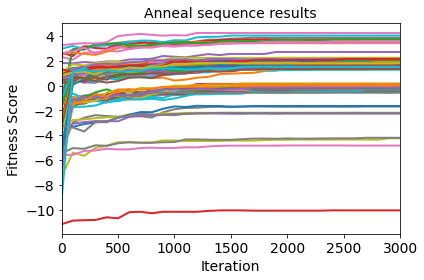

--- [Experiment 1] perturb_improve_max_score_no_motifs_3000_iters_100_seqs_score_ix_2_ct_1_ix_0_ct_2_ix_6_target_dist_20 ---
--- Optimizing batch = 0 ---
Finished optimizing 100 sequences.


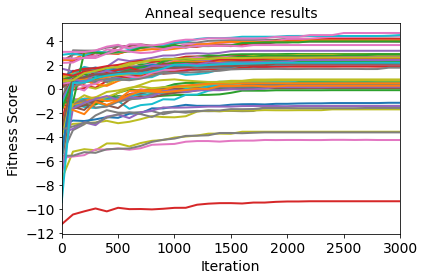

--- [Experiment 2] perturb_improve_max_score_no_motifs_3000_iters_100_seqs_score_ix_2_ct_1_ix_0_ct_2_ix_6_target_dist_40 ---
--- Optimizing batch = 0 ---
Finished optimizing 100 sequences.


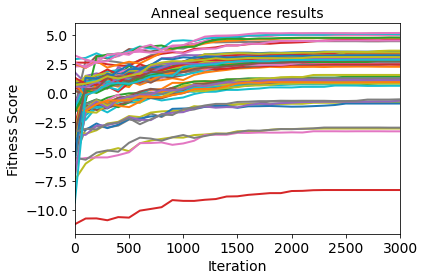

In [55]:
#Run the basinhopping algorithm (multiple conditions)

#Global parameters
sequence_template = 'N' * 70 + 'XXXXXX' + 'X' * 70
batch_size = 100
n_iters_per_temperature = 100

seq_start = 0
seq_end = 146

n_backgrounds = 8
min_qtl = 0.8

#Get sequence encoder
acgt_encoder = OneHotEncoder(seq_end - seq_start, {'A':0, 'C':1, 'G':2, 'T':3})

verbose = False

#Experiment-specific configuration
configs = [
    {'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_2/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_6_score_ix_2_n_sequences_100_up_window_size_9_pos.txt', 'target_dist' : 10, 'score_ix' : 2, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [6], 'motif_blacklist_set' : 1},
    {'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_2/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_6_score_ix_2_n_sequences_100_up_window_size_9_pos.txt', 'target_dist' : 20, 'score_ix' : 2, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [6], 'motif_blacklist_set' : 1},
    {'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_2/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_6_score_ix_2_n_sequences_100_up_window_size_9_pos.txt', 'target_dist' : 40, 'score_ix' : 2, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [6], 'motif_blacklist_set' : 1},
]

for config_ix, config in enumerate(configs) :

    n_sequences = config['n_sequences']
    n_iters = config['n_iters']
    target_score = config['target_score']
    max_min = config['max_min']
    
    init_sequence_file = config['init_sequence_file']
    target_dist = config['target_dist']
    
    min_gc = config['min_gc'] if 'min_gc' in config else 0.0
    max_gc = config['max_gc'] if 'max_gc' in config else 1.0
    min_g = config['min_g'] if 'min_g' in config else 0.0
    max_g = config['max_g'] if 'max_g' in config else 1.0
    min_c = config['min_c'] if 'min_c' in config else 0.0
    max_c = config['max_c'] if 'max_c' in config else 1.0

    score_ix = config['score_ix']
    cell_type_1_ix = config['cell_type_1_ix']
    cell_type_2_ix = config['cell_type_2_ix']

    motif_blacklist_set = config['motif_blacklist_set']
    
    target_score_str = "target_score_" + str(target_score).replace(".", "_") if target_score is not None else max_min + "_score"
    gc_str = ("_min_gc_" + str(min_gc).replace(".", "") + "_max_gc_" + str(max_gc).replace(".", "")) if min_gc > 0.0 or max_gc < 1.0 else ""
    g_str = ("_min_g_" + str(min_g).replace(".", "") + "_max_g_" + str(max_g).replace(".", "")) if min_g > 0.0 or max_g < 1.0 else ""
    c_str = ("_min_c_" + str(min_c).replace(".", "") + "_max_c_" + str(max_c).replace(".", "")) if min_c > 0.0 or max_c < 1.0 else ""
    motif_str = "_no_motifs" if motif_blacklist_set == 1 else ("_no_motifs_strict" if motif_blacklist_set == 2 else "")

    cell_type_1_ix_str = "_and_".join([str(cell_type_1_ix[ii]) for ii in range(len(cell_type_1_ix))])
    cell_type_2_ix_str = "_and_".join([str(cell_type_2_ix[jj]) for jj in range(len(cell_type_2_ix))])
    
    run_prefix = "perturb_improve_" + target_score_str + gc_str + g_str + c_str + motif_str + "_" + str(n_iters) + "_iters_" + str(n_sequences) + "_seqs_" + "score_ix_" + str(score_ix) + "_ct_1_ix_" + cell_type_1_ix_str + "_ct_2_ix_" + cell_type_2_ix_str + "_target_dist_" + str(int(target_dist))

    print("--- [Experiment " + str(config_ix) + "] " + run_prefix + " ---")
    
    #Load start sequences
    init_sequences = pd.read_csv(init_sequence_file, sep='\t').query("experiment == 'wt'").iloc[:n_sequences]['seq'].str.slice(0, len(sequence_template)).values.tolist()
    
    #Generate a set of backgrounds
    flat_ts_diff = np.mean(flat_ts[:, cell_type_1_ix, score_ix], axis=-1) - np.mean(flat_ts[:, cell_type_2_ix, score_ix], axis=-1)

    keep_index = np.nonzero(flat_ts_diff >= np.quantile(flat_ts_diff, q=min_qtl))[0]

    background_index = np.random.choice(keep_index, size=(n_backgrounds,), replace=True).tolist()

    background_up = flat_x[background_index, :, :seq_start, :]
    background_dn = flat_x[background_index, :, seq_end:, :]

    #Decode and store backgrounds
    background_up_encoder = OneHotEncoder(seq_start, {'A':0, 'C':1, 'G':2, 'T':3}) if seq_start > 0 else None
    background_dn_encoder = OneHotEncoder(205 - seq_end, {'A':0, 'C':1, 'G':2, 'T':3}) if 205 - seq_end > 0 else None
    
    background_up_strs = [
        background_up_encoder.decode(background_up[bg_ix, 0, ...]) for bg_ix in range(background_up.shape[0])
    ] if background_up_encoder is not None else ["" for _ in range(background_up.shape[0])]
    
    background_dn_strs = [
        background_dn_encoder.decode(background_dn[bg_ix, 0, ...]) for bg_ix in range(background_dn.shape[0])
    ] if background_dn_encoder is not None else ["" for _ in range(background_dn.shape[0])]
    
    run_dir = "./samples/" + run_prefix + "/"
    if not os.path.exists(run_dir):
        os.makedirs(run_dir)
    
    with open(run_dir + "backgrounds_upstream.txt", "w") as f :
        for background_up_str in background_up_strs :
            f.write(background_up_str + "\n")
    
    with open(run_dir + "backgrounds_downstream.txt", "w") as f :
        for background_dn_str in background_dn_strs :
            f.write(background_dn_str + "\n")
    
    #Get templated predict function
    predict_func = get_predict_multi_model_multi_background(background_up, background_dn)
    
    t_init = 0.1
    t_func = lambda t, curr_iter, t_init=t_init, total_iters=n_iters, t_min=0.05, exp_scale=1./0.7: t_init * t_min**(min(float(curr_iter / total_iters) * exp_scale, 1.0))

    '''
    f = plt.figure(figsize=(6, 4))

    it_space = [0] + [(epoch_ix + 1) * n_iters_per_temperature for epoch_ix in range(n_iters // n_iters_per_temperature)]
    temp = t_init
    temp_space = [temp]
    for j in range(1, len(it_space)) :
        it = it_space[j]
        temp = t_func(temp, it)
        temp_space.append(temp)

    plt.plot(it_space, temp_space, linewidth=2, color='black', linestyle='-')

    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Temperature", fontsize=14)
    plt.title("Anneal schedule", fontsize=14)

    plt.xlim(0, np.max(it_space))

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()
    '''

    optimized_seqs, optimized_trajs = run_simulated_annealing_batched(n_sequences, batch_size, run_prefix, predict_func, tissue_models, score_ix, cell_type_1_ix, cell_type_2_ix, target_score, max_min, min_gc, max_gc, min_g, max_g, min_c, max_c, motif_blacklist_set, init_sequences, target_dist, sequence_template, acgt_encoder, n_iters=n_iters, n_iters_per_temperature=n_iters_per_temperature, temperature_init=t_init, temperature_func=t_func, verbose=verbose)

    print("Finished optimizing " + str(optimized_trajs.shape[0]) + " sequences.")

    plot_n_trajs = min(optimized_trajs.shape[0], 500)

    f = plt.figure(figsize=(6, 4))

    it_space = [0] + [(epoch_ix + 1) * n_iters_per_temperature for epoch_ix in range(n_iters // n_iters_per_temperature)]

    for i in range(plot_n_trajs) :
        plt.plot(it_space, optimized_trajs[i, :], linewidth=2, linestyle='-')

    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Fitness Score", fontsize=14)
    plt.title("Anneal sequence results", fontsize=14)

    plt.xlim(0, np.max(it_space))

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()


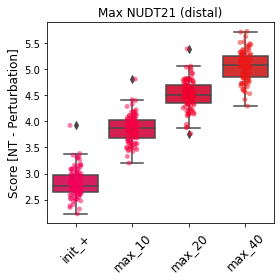

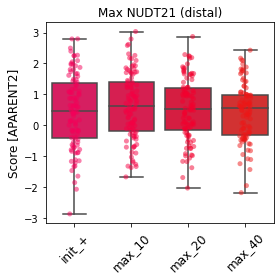

In [15]:
#Re-load, predict and visualize sequence design distributions

plot_title = "Max NUDT21 (distal)"

#Global parameters
sequence_template = 'N' * 70 + 'XXXXXX' + 'X' * 70
batch_size = 100
n_iters_per_temperature = 100

seq_start = 0
seq_end = 146

n_backgrounds = 8
min_qtl = 0.8

up_bg = ""
dn_bg = "GCATTTTTATTTTGATTTTGATGCTGATGTACCGAAGGGTTGTTTTGTGTTTACGTAGA"

#Get sequence encoder
acgt_encoder = OneHotEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})

#Experiment-specific configuration
configs = [
    {'name' : 'init_+', 'n_sequences' : 100, 'score_ix' : 2, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [6], 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_2/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_6_score_ix_2_n_sequences_100_up_window_size_9_pos.txt'},
    
    {'name' : 'max_10', 'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_2/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_6_score_ix_2_n_sequences_100_up_window_size_9_pos.txt', 'target_dist' : 10, 'score_ix' : 2, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [6], 'motif_blacklist_set' : 1},
    
    {'name' : 'max_20', 'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_2/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_6_score_ix_2_n_sequences_100_up_window_size_9_pos.txt', 'target_dist' : 20, 'score_ix' : 2, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [6], 'motif_blacklist_set' : 1},
    
    {'name' : 'max_40', 'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_2/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_6_score_ix_2_n_sequences_100_up_window_size_9_pos.txt', 'target_dist' : 40, 'score_ix' : 2, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [6], 'motif_blacklist_set' : 1},
]

names = []
x_gens = []
y_gens = []
a_gens = []

colors = ['#f40059', '#f50043', '#f3002e', '#ed1717']

for config_ix, config in enumerate(configs) :

    name = config['name']
    names.append(name)
    
    if "init_" in name :
        n_sequences = config['n_sequences']
        init_sequence_file = config['init_sequence_file']
        
        score_ix = config['score_ix']
        cell_type_1_ix = config['cell_type_1_ix']
        cell_type_2_ix = config['cell_type_2_ix']
        
        x_gen = []
        init_df = pd.read_csv(init_sequence_file, sep='\t').query("experiment == 'wt'").iloc[:n_sequences]
        for _, row in init_df.iterrows() :
            x_gen.append(
                acgt_encoder.encode(up_bg + row['seq'][:seq_end] + dn_bg)[None, None, ...]
            )

        x_gen = np.concatenate(x_gen, axis=0)[:n_sequences]
        x_gens.append(x_gen)

        ts = _predict_multi_model(tissue_models, x_gen, batch_size=32)
        y_gen = np.mean(ts[:, cell_type_1_ix, score_ix], axis=-1) - np.mean(ts[:, cell_type_2_ix, score_ix], axis=-1)
        y_gens.append(y_gen)
        
        l_gen = np.zeros((x_gen.shape[0], 13))
        l_gen[:, 11] = 1.
        d_gen = np.zeros((x_gen.shape[0], 1))
        
        a_gen = aparent.predict(x=[x_gen, l_gen, d_gen], batch_size=32)[:, 0]
        a_gens.append(a_gen)
    else :
        n_sequences = config['n_sequences']
        n_iters = config['n_iters']
        target_score = config['target_score']
        max_min = config['max_min']

        init_sequence_file = config['init_sequence_file']
        target_dist = config['target_dist']

        min_gc = config['min_gc'] if 'min_gc' in config else 0.0
        max_gc = config['max_gc'] if 'max_gc' in config else 1.0
        min_g = config['min_g'] if 'min_g' in config else 0.0
        max_g = config['max_g'] if 'max_g' in config else 1.0
        min_c = config['min_c'] if 'min_c' in config else 0.0
        max_c = config['max_c'] if 'max_c' in config else 1.0

        score_ix = config['score_ix']
        cell_type_1_ix = config['cell_type_1_ix']
        cell_type_2_ix = config['cell_type_2_ix']

        motif_blacklist_set = config['motif_blacklist_set']

        target_score_str = "target_score_" + str(target_score).replace(".", "_") if target_score is not None else max_min + "_score"
        gc_str = ("_min_gc_" + str(min_gc).replace(".", "") + "_max_gc_" + str(max_gc).replace(".", "")) if min_gc > 0.0 or max_gc < 1.0 else ""
        g_str = ("_min_g_" + str(min_g).replace(".", "") + "_max_g_" + str(max_g).replace(".", "")) if min_g > 0.0 or max_g < 1.0 else ""
        c_str = ("_min_c_" + str(min_c).replace(".", "") + "_max_c_" + str(max_c).replace(".", "")) if min_c > 0.0 or max_c < 1.0 else ""
        motif_str = "_no_motifs" if motif_blacklist_set == 1 else ("_no_motifs_strict" if motif_blacklist_set == 2 else "")

        cell_type_1_ix_str = "_and_".join([str(cell_type_1_ix[ii]) for ii in range(len(cell_type_1_ix))])
        cell_type_2_ix_str = "_and_".join([str(cell_type_2_ix[jj]) for jj in range(len(cell_type_2_ix))])

        run_prefix = "perturb_improve_" + target_score_str + gc_str + g_str + c_str + motif_str + "_" + str(n_iters) + "_iters_" + str(n_sequences) + "_seqs_" + "score_ix_" + str(score_ix) + "_ct_1_ix_" + cell_type_1_ix_str + "_ct_2_ix_" + cell_type_2_ix_str + "_target_dist_" + str(int(target_dist))

        x_gen = []
        with open('samples/' + run_prefix + '/intermediate_iter_3000.txt', 'rt') as f :

            for line in f.readlines() :
                x_gen.append(
                    acgt_encoder.encode(up_bg + line.strip() + dn_bg)[None, None, ...]
                )

        x_gen = np.concatenate(x_gen, axis=0)[:n_sequences]
        x_gens.append(x_gen)

        ts = _predict_multi_model(tissue_models, x_gen, batch_size=32)
        y_gen = np.mean(ts[:, cell_type_1_ix, score_ix], axis=-1) - np.mean(ts[:, cell_type_2_ix, score_ix], axis=-1)
        y_gens.append(y_gen)
        
        l_gen = np.zeros((x_gen.shape[0], 13))
        l_gen[:, 11] = 1.
        d_gen = np.zeros((x_gen.shape[0], 1))
        
        a_gen = aparent.predict(x=[x_gen, l_gen, d_gen], batch_size=32)[:, 0]
        a_gens.append(a_gen)

#Plot predictions
import seaborn as sns

min_y = 2.0
max_y = 6.0

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=y_gens, palette=colors)
sns.stripplot(data=y_gens, palette=colors, alpha=0.5)

plt.xticks(np.arange(len(names)), names, fontsize=12, rotation=45)
plt.ylabel("Score [NT - Perturbation]", fontsize=12)

plt.title(plot_title, fontsize=12)

#plt.ylim(min_y, max_y)

plt.tight_layout()

plt.show()

#Plot predictions (aparent2)
import seaborn as sns

min_y = 2.0
max_y = 6.0

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=a_gens, palette=colors)
sns.stripplot(data=a_gens, palette=colors, alpha=0.5)

plt.xticks(np.arange(len(names)), names, fontsize=12, rotation=45)
plt.ylabel("Score [APARENT2]", fontsize=12)

plt.title(plot_title, fontsize=12)

#plt.ylim(min_y, max_y)

plt.tight_layout()

plt.show()


--- [Experiment 0] perturb_improve_max_score_no_motifs_3000_iters_100_seqs_score_ix_0_ct_1_ix_0_ct_2_ix_6_target_dist_10 ---
--- Optimizing batch = 0 ---
Finished optimizing 100 sequences.


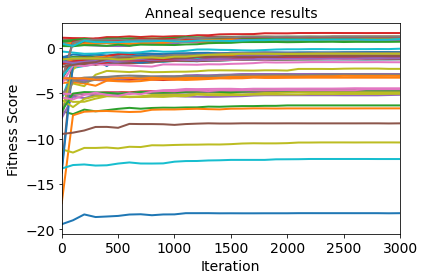

--- [Experiment 1] perturb_improve_max_score_no_motifs_3000_iters_100_seqs_score_ix_0_ct_1_ix_0_ct_2_ix_6_target_dist_20 ---
--- Optimizing batch = 0 ---
Finished optimizing 100 sequences.


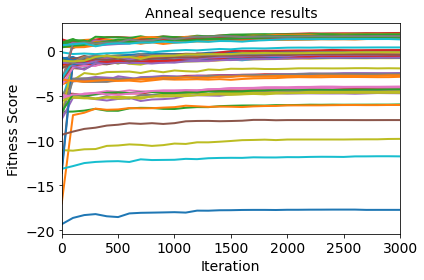

--- [Experiment 2] perturb_improve_max_score_no_motifs_3000_iters_100_seqs_score_ix_0_ct_1_ix_0_ct_2_ix_6_target_dist_40 ---
--- Optimizing batch = 0 ---
Finished optimizing 100 sequences.


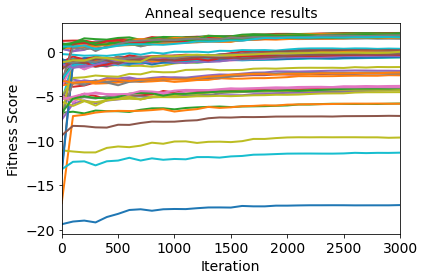

In [56]:
#Run the basinhopping algorithm (multiple conditions)

#Global parameters
sequence_template = 'N' * 70 + 'XXXXXX' + 'X' * 70
batch_size = 100
n_iters_per_temperature = 100

seq_start = 0
seq_end = 146

n_backgrounds = 8
min_qtl = 0.8

#Get sequence encoder
acgt_encoder = OneHotEncoder(seq_end - seq_start, {'A':0, 'C':1, 'G':2, 'T':3})

verbose = False

#Experiment-specific configuration
configs = [
    {'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_0/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_6_score_ix_0_n_sequences_100_up_window_size_9_pos.txt', 'target_dist' : 10, 'score_ix' : 0, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [6], 'motif_blacklist_set' : 1},
    {'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_0/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_6_score_ix_0_n_sequences_100_up_window_size_9_pos.txt', 'target_dist' : 20, 'score_ix' : 0, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [6], 'motif_blacklist_set' : 1},
    {'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_0/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_6_score_ix_0_n_sequences_100_up_window_size_9_pos.txt', 'target_dist' : 40, 'score_ix' : 0, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [6], 'motif_blacklist_set' : 1},
]

for config_ix, config in enumerate(configs) :

    n_sequences = config['n_sequences']
    n_iters = config['n_iters']
    target_score = config['target_score']
    max_min = config['max_min']
    
    init_sequence_file = config['init_sequence_file']
    target_dist = config['target_dist']
    
    min_gc = config['min_gc'] if 'min_gc' in config else 0.0
    max_gc = config['max_gc'] if 'max_gc' in config else 1.0
    min_g = config['min_g'] if 'min_g' in config else 0.0
    max_g = config['max_g'] if 'max_g' in config else 1.0
    min_c = config['min_c'] if 'min_c' in config else 0.0
    max_c = config['max_c'] if 'max_c' in config else 1.0

    score_ix = config['score_ix']
    cell_type_1_ix = config['cell_type_1_ix']
    cell_type_2_ix = config['cell_type_2_ix']

    motif_blacklist_set = config['motif_blacklist_set']
    
    target_score_str = "target_score_" + str(target_score).replace(".", "_") if target_score is not None else max_min + "_score"
    gc_str = ("_min_gc_" + str(min_gc).replace(".", "") + "_max_gc_" + str(max_gc).replace(".", "")) if min_gc > 0.0 or max_gc < 1.0 else ""
    g_str = ("_min_g_" + str(min_g).replace(".", "") + "_max_g_" + str(max_g).replace(".", "")) if min_g > 0.0 or max_g < 1.0 else ""
    c_str = ("_min_c_" + str(min_c).replace(".", "") + "_max_c_" + str(max_c).replace(".", "")) if min_c > 0.0 or max_c < 1.0 else ""
    motif_str = "_no_motifs" if motif_blacklist_set == 1 else ("_no_motifs_strict" if motif_blacklist_set == 2 else "")

    cell_type_1_ix_str = "_and_".join([str(cell_type_1_ix[ii]) for ii in range(len(cell_type_1_ix))])
    cell_type_2_ix_str = "_and_".join([str(cell_type_2_ix[jj]) for jj in range(len(cell_type_2_ix))])
    
    run_prefix = "perturb_improve_" + target_score_str + gc_str + g_str + c_str + motif_str + "_" + str(n_iters) + "_iters_" + str(n_sequences) + "_seqs_" + "score_ix_" + str(score_ix) + "_ct_1_ix_" + cell_type_1_ix_str + "_ct_2_ix_" + cell_type_2_ix_str + "_target_dist_" + str(int(target_dist))

    print("--- [Experiment " + str(config_ix) + "] " + run_prefix + " ---")
    
    #Load start sequences
    init_sequences = pd.read_csv(init_sequence_file, sep='\t').query("experiment == 'wt'").iloc[:n_sequences]['seq'].str.slice(0, len(sequence_template)).values.tolist()
    
    #Generate a set of backgrounds
    flat_ts_diff = np.mean(flat_ts[:, cell_type_1_ix, score_ix], axis=-1) - np.mean(flat_ts[:, cell_type_2_ix, score_ix], axis=-1)

    keep_index = np.nonzero(flat_ts_diff >= np.quantile(flat_ts_diff, q=min_qtl))[0]

    background_index = np.random.choice(keep_index, size=(n_backgrounds,), replace=True).tolist()

    background_up = flat_x[background_index, :, :seq_start, :]
    background_dn = flat_x[background_index, :, seq_end:, :]

    #Decode and store backgrounds
    background_up_encoder = OneHotEncoder(seq_start, {'A':0, 'C':1, 'G':2, 'T':3}) if seq_start > 0 else None
    background_dn_encoder = OneHotEncoder(205 - seq_end, {'A':0, 'C':1, 'G':2, 'T':3}) if 205 - seq_end > 0 else None
    
    background_up_strs = [
        background_up_encoder.decode(background_up[bg_ix, 0, ...]) for bg_ix in range(background_up.shape[0])
    ] if background_up_encoder is not None else ["" for _ in range(background_up.shape[0])]
    
    background_dn_strs = [
        background_dn_encoder.decode(background_dn[bg_ix, 0, ...]) for bg_ix in range(background_dn.shape[0])
    ] if background_dn_encoder is not None else ["" for _ in range(background_dn.shape[0])]
    
    run_dir = "./samples/" + run_prefix + "/"
    if not os.path.exists(run_dir):
        os.makedirs(run_dir)
    
    with open(run_dir + "backgrounds_upstream.txt", "w") as f :
        for background_up_str in background_up_strs :
            f.write(background_up_str + "\n")
    
    with open(run_dir + "backgrounds_downstream.txt", "w") as f :
        for background_dn_str in background_dn_strs :
            f.write(background_dn_str + "\n")
    
    #Get templated predict function
    predict_func = get_predict_multi_model_multi_background(background_up, background_dn)
    
    t_init = 0.1
    t_func = lambda t, curr_iter, t_init=t_init, total_iters=n_iters, t_min=0.05, exp_scale=1./0.7: t_init * t_min**(min(float(curr_iter / total_iters) * exp_scale, 1.0))

    '''
    f = plt.figure(figsize=(6, 4))

    it_space = [0] + [(epoch_ix + 1) * n_iters_per_temperature for epoch_ix in range(n_iters // n_iters_per_temperature)]
    temp = t_init
    temp_space = [temp]
    for j in range(1, len(it_space)) :
        it = it_space[j]
        temp = t_func(temp, it)
        temp_space.append(temp)

    plt.plot(it_space, temp_space, linewidth=2, color='black', linestyle='-')

    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Temperature", fontsize=14)
    plt.title("Anneal schedule", fontsize=14)

    plt.xlim(0, np.max(it_space))

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()
    '''

    optimized_seqs, optimized_trajs = run_simulated_annealing_batched(n_sequences, batch_size, run_prefix, predict_func, tissue_models, score_ix, cell_type_1_ix, cell_type_2_ix, target_score, max_min, min_gc, max_gc, min_g, max_g, min_c, max_c, motif_blacklist_set, init_sequences, target_dist, sequence_template, acgt_encoder, n_iters=n_iters, n_iters_per_temperature=n_iters_per_temperature, temperature_init=t_init, temperature_func=t_func, verbose=verbose)

    print("Finished optimizing " + str(optimized_trajs.shape[0]) + " sequences.")

    plot_n_trajs = min(optimized_trajs.shape[0], 500)

    f = plt.figure(figsize=(6, 4))

    it_space = [0] + [(epoch_ix + 1) * n_iters_per_temperature for epoch_ix in range(n_iters // n_iters_per_temperature)]

    for i in range(plot_n_trajs) :
        plt.plot(it_space, optimized_trajs[i, :], linewidth=2, linestyle='-')

    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Fitness Score", fontsize=14)
    plt.title("Anneal sequence results", fontsize=14)

    plt.xlim(0, np.max(it_space))

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()


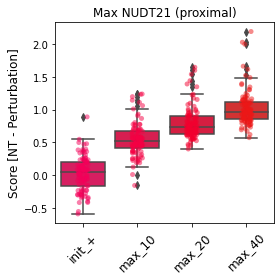

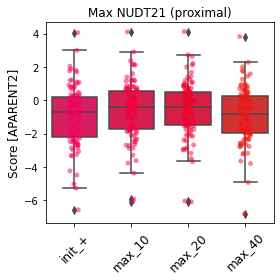

In [16]:
#Re-load, predict and visualize sequence design distributions

plot_title = "Max NUDT21 (proximal)"

#Global parameters
sequence_template = 'N' * 70 + 'XXXXXX' + 'X' * 70
batch_size = 100
n_iters_per_temperature = 100

seq_start = 0
seq_end = 146

n_backgrounds = 8
min_qtl = 0.8

up_bg = ""
dn_bg = "GCATTTTTATTTTGATTTTGATGCTGATGTACCGAAGGGTTGTTTTGTGTTTACGTAGA"

#Get sequence encoder
acgt_encoder = OneHotEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})

#Experiment-specific configuration
configs = [
    {'name' : 'init_+', 'n_sequences' : 100, 'score_ix' : 0, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [6], 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_0/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_6_score_ix_0_n_sequences_100_up_window_size_9_pos.txt'},
    
    {'name' : 'max_10', 'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_0/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_6_score_ix_0_n_sequences_100_up_window_size_9_pos.txt', 'target_dist' : 10, 'score_ix' : 0, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [6], 'motif_blacklist_set' : 1},
    
    {'name' : 'max_20', 'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_0/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_6_score_ix_0_n_sequences_100_up_window_size_9_pos.txt', 'target_dist' : 20, 'score_ix' : 0, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [6], 'motif_blacklist_set' : 1},
    
    {'name' : 'max_40', 'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_0/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_6_score_ix_0_n_sequences_100_up_window_size_9_pos.txt', 'target_dist' : 40, 'score_ix' : 0, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [6], 'motif_blacklist_set' : 1},
]

names = []
x_gens = []
y_gens = []
a_gens = []

colors = ['#f40059', '#f50043', '#f3002e', '#ed1717']

for config_ix, config in enumerate(configs) :

    name = config['name']
    names.append(name)
    
    if "init_" in name :
        n_sequences = config['n_sequences']
        init_sequence_file = config['init_sequence_file']
        
        score_ix = config['score_ix']
        cell_type_1_ix = config['cell_type_1_ix']
        cell_type_2_ix = config['cell_type_2_ix']
        
        x_gen = []
        init_df = pd.read_csv(init_sequence_file, sep='\t').query("experiment == 'wt'").iloc[:n_sequences]
        for _, row in init_df.iterrows() :
            x_gen.append(
                acgt_encoder.encode(up_bg + row['seq'][:seq_end] + dn_bg)[None, None, ...]
            )

        x_gen = np.concatenate(x_gen, axis=0)[:n_sequences]
        x_gens.append(x_gen)

        ts = _predict_multi_model(tissue_models, x_gen, batch_size=32)
        y_gen = np.mean(ts[:, cell_type_1_ix, score_ix], axis=-1) - np.mean(ts[:, cell_type_2_ix, score_ix], axis=-1)
        y_gens.append(y_gen)
        
        l_gen = np.zeros((x_gen.shape[0], 13))
        l_gen[:, 11] = 1.
        d_gen = np.zeros((x_gen.shape[0], 1))
        
        a_gen = aparent.predict(x=[x_gen, l_gen, d_gen], batch_size=32)[:, 0]
        a_gens.append(a_gen)
    else :
        n_sequences = config['n_sequences']
        n_iters = config['n_iters']
        target_score = config['target_score']
        max_min = config['max_min']

        init_sequence_file = config['init_sequence_file']
        target_dist = config['target_dist']

        min_gc = config['min_gc'] if 'min_gc' in config else 0.0
        max_gc = config['max_gc'] if 'max_gc' in config else 1.0
        min_g = config['min_g'] if 'min_g' in config else 0.0
        max_g = config['max_g'] if 'max_g' in config else 1.0
        min_c = config['min_c'] if 'min_c' in config else 0.0
        max_c = config['max_c'] if 'max_c' in config else 1.0

        score_ix = config['score_ix']
        cell_type_1_ix = config['cell_type_1_ix']
        cell_type_2_ix = config['cell_type_2_ix']

        motif_blacklist_set = config['motif_blacklist_set']

        target_score_str = "target_score_" + str(target_score).replace(".", "_") if target_score is not None else max_min + "_score"
        gc_str = ("_min_gc_" + str(min_gc).replace(".", "") + "_max_gc_" + str(max_gc).replace(".", "")) if min_gc > 0.0 or max_gc < 1.0 else ""
        g_str = ("_min_g_" + str(min_g).replace(".", "") + "_max_g_" + str(max_g).replace(".", "")) if min_g > 0.0 or max_g < 1.0 else ""
        c_str = ("_min_c_" + str(min_c).replace(".", "") + "_max_c_" + str(max_c).replace(".", "")) if min_c > 0.0 or max_c < 1.0 else ""
        motif_str = "_no_motifs" if motif_blacklist_set == 1 else ("_no_motifs_strict" if motif_blacklist_set == 2 else "")

        cell_type_1_ix_str = "_and_".join([str(cell_type_1_ix[ii]) for ii in range(len(cell_type_1_ix))])
        cell_type_2_ix_str = "_and_".join([str(cell_type_2_ix[jj]) for jj in range(len(cell_type_2_ix))])

        run_prefix = "perturb_improve_" + target_score_str + gc_str + g_str + c_str + motif_str + "_" + str(n_iters) + "_iters_" + str(n_sequences) + "_seqs_" + "score_ix_" + str(score_ix) + "_ct_1_ix_" + cell_type_1_ix_str + "_ct_2_ix_" + cell_type_2_ix_str + "_target_dist_" + str(int(target_dist))

        x_gen = []
        with open('samples/' + run_prefix + '/intermediate_iter_3000.txt', 'rt') as f :

            for line in f.readlines() :
                x_gen.append(
                    acgt_encoder.encode(up_bg + line.strip() + dn_bg)[None, None, ...]
                )

        x_gen = np.concatenate(x_gen, axis=0)[:n_sequences]
        x_gens.append(x_gen)

        ts = _predict_multi_model(tissue_models, x_gen, batch_size=32)
        y_gen = np.mean(ts[:, cell_type_1_ix, score_ix], axis=-1) - np.mean(ts[:, cell_type_2_ix, score_ix], axis=-1)
        y_gens.append(y_gen)
        
        l_gen = np.zeros((x_gen.shape[0], 13))
        l_gen[:, 11] = 1.
        d_gen = np.zeros((x_gen.shape[0], 1))
        
        a_gen = aparent.predict(x=[x_gen, l_gen, d_gen], batch_size=32)[:, 0]
        a_gens.append(a_gen)

#Plot predictions
import seaborn as sns

min_y = 2.0
max_y = 6.0

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=y_gens, palette=colors)
sns.stripplot(data=y_gens, palette=colors, alpha=0.5)

plt.xticks(np.arange(len(names)), names, fontsize=12, rotation=45)
plt.ylabel("Score [NT - Perturbation]", fontsize=12)

plt.title(plot_title, fontsize=12)

#plt.ylim(min_y, max_y)

plt.tight_layout()

plt.show()

#Plot predictions (aparent2)
import seaborn as sns

min_y = 2.0
max_y = 6.0

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=a_gens, palette=colors)
sns.stripplot(data=a_gens, palette=colors, alpha=0.5)

plt.xticks(np.arange(len(names)), names, fontsize=12, rotation=45)
plt.ylabel("Score [APARENT2]", fontsize=12)

plt.title(plot_title, fontsize=12)

#plt.ylim(min_y, max_y)

plt.tight_layout()

plt.show()


--- [Experiment 0] perturb_improve_max_score_no_motifs_3000_iters_100_seqs_score_ix_2_ct_1_ix_0_ct_2_ix_4_target_dist_10 ---
--- Optimizing batch = 0 ---
Finished optimizing 100 sequences.


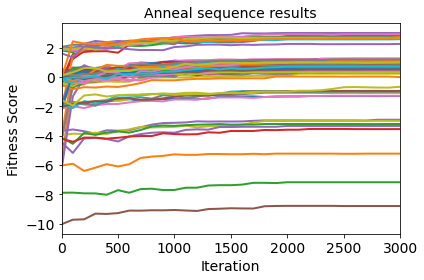

--- [Experiment 1] perturb_improve_max_score_no_motifs_3000_iters_100_seqs_score_ix_2_ct_1_ix_0_ct_2_ix_4_target_dist_20 ---
--- Optimizing batch = 0 ---
Finished optimizing 100 sequences.


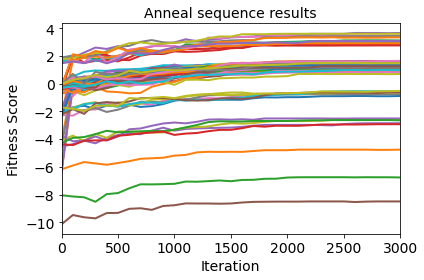

--- [Experiment 2] perturb_improve_max_score_no_motifs_3000_iters_100_seqs_score_ix_2_ct_1_ix_0_ct_2_ix_4_target_dist_40 ---
--- Optimizing batch = 0 ---
Finished optimizing 100 sequences.


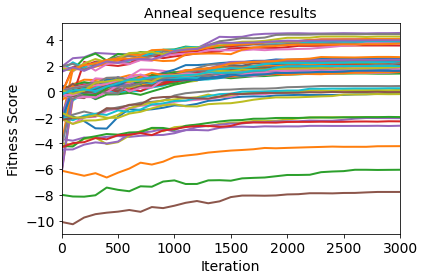

In [57]:
#Run the basinhopping algorithm (multiple conditions)

#Global parameters
sequence_template = 'X' * 70 + 'XXXXXX' + 'N' * 70
batch_size = 100
n_iters_per_temperature = 100

seq_start = 0
seq_end = 146

n_backgrounds = 8
min_qtl = 0.8

#Get sequence encoder
acgt_encoder = OneHotEncoder(seq_end - seq_start, {'A':0, 'C':1, 'G':2, 'T':3})

verbose = False

#Experiment-specific configuration
configs = [
    {'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_2/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_4_score_ix_2_n_sequences_100_dn_window_size_9_pos.txt', 'target_dist' : 10, 'score_ix' : 2, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [4], 'motif_blacklist_set' : 1},
    {'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_2/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_4_score_ix_2_n_sequences_100_dn_window_size_9_pos.txt', 'target_dist' : 20, 'score_ix' : 2, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [4], 'motif_blacklist_set' : 1},
    {'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_2/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_4_score_ix_2_n_sequences_100_dn_window_size_9_pos.txt', 'target_dist' : 40, 'score_ix' : 2, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [4], 'motif_blacklist_set' : 1},
]

for config_ix, config in enumerate(configs) :

    n_sequences = config['n_sequences']
    n_iters = config['n_iters']
    target_score = config['target_score']
    max_min = config['max_min']
    
    init_sequence_file = config['init_sequence_file']
    target_dist = config['target_dist']
    
    min_gc = config['min_gc'] if 'min_gc' in config else 0.0
    max_gc = config['max_gc'] if 'max_gc' in config else 1.0
    min_g = config['min_g'] if 'min_g' in config else 0.0
    max_g = config['max_g'] if 'max_g' in config else 1.0
    min_c = config['min_c'] if 'min_c' in config else 0.0
    max_c = config['max_c'] if 'max_c' in config else 1.0

    score_ix = config['score_ix']
    cell_type_1_ix = config['cell_type_1_ix']
    cell_type_2_ix = config['cell_type_2_ix']

    motif_blacklist_set = config['motif_blacklist_set']
    
    target_score_str = "target_score_" + str(target_score).replace(".", "_") if target_score is not None else max_min + "_score"
    gc_str = ("_min_gc_" + str(min_gc).replace(".", "") + "_max_gc_" + str(max_gc).replace(".", "")) if min_gc > 0.0 or max_gc < 1.0 else ""
    g_str = ("_min_g_" + str(min_g).replace(".", "") + "_max_g_" + str(max_g).replace(".", "")) if min_g > 0.0 or max_g < 1.0 else ""
    c_str = ("_min_c_" + str(min_c).replace(".", "") + "_max_c_" + str(max_c).replace(".", "")) if min_c > 0.0 or max_c < 1.0 else ""
    motif_str = "_no_motifs" if motif_blacklist_set == 1 else ("_no_motifs_strict" if motif_blacklist_set == 2 else "")

    cell_type_1_ix_str = "_and_".join([str(cell_type_1_ix[ii]) for ii in range(len(cell_type_1_ix))])
    cell_type_2_ix_str = "_and_".join([str(cell_type_2_ix[jj]) for jj in range(len(cell_type_2_ix))])
    
    run_prefix = "perturb_improve_" + target_score_str + gc_str + g_str + c_str + motif_str + "_" + str(n_iters) + "_iters_" + str(n_sequences) + "_seqs_" + "score_ix_" + str(score_ix) + "_ct_1_ix_" + cell_type_1_ix_str + "_ct_2_ix_" + cell_type_2_ix_str + "_target_dist_" + str(int(target_dist))

    print("--- [Experiment " + str(config_ix) + "] " + run_prefix + " ---")
    
    #Load start sequences
    init_sequences = pd.read_csv(init_sequence_file, sep='\t').query("experiment == 'wt'").iloc[:n_sequences]['seq'].str.slice(0, len(sequence_template)).values.tolist()
    
    #Generate a set of backgrounds
    flat_ts_diff = np.mean(flat_ts[:, cell_type_1_ix, score_ix], axis=-1) - np.mean(flat_ts[:, cell_type_2_ix, score_ix], axis=-1)

    keep_index = np.nonzero(flat_ts_diff >= np.quantile(flat_ts_diff, q=min_qtl))[0]

    background_index = np.random.choice(keep_index, size=(n_backgrounds,), replace=True).tolist()

    background_up = flat_x[background_index, :, :seq_start, :]
    background_dn = flat_x[background_index, :, seq_end:, :]

    #Decode and store backgrounds
    background_up_encoder = OneHotEncoder(seq_start, {'A':0, 'C':1, 'G':2, 'T':3}) if seq_start > 0 else None
    background_dn_encoder = OneHotEncoder(205 - seq_end, {'A':0, 'C':1, 'G':2, 'T':3}) if 205 - seq_end > 0 else None
    
    background_up_strs = [
        background_up_encoder.decode(background_up[bg_ix, 0, ...]) for bg_ix in range(background_up.shape[0])
    ] if background_up_encoder is not None else ["" for _ in range(background_up.shape[0])]
    
    background_dn_strs = [
        background_dn_encoder.decode(background_dn[bg_ix, 0, ...]) for bg_ix in range(background_dn.shape[0])
    ] if background_dn_encoder is not None else ["" for _ in range(background_dn.shape[0])]
    
    run_dir = "./samples/" + run_prefix + "/"
    if not os.path.exists(run_dir):
        os.makedirs(run_dir)
    
    with open(run_dir + "backgrounds_upstream.txt", "w") as f :
        for background_up_str in background_up_strs :
            f.write(background_up_str + "\n")
    
    with open(run_dir + "backgrounds_downstream.txt", "w") as f :
        for background_dn_str in background_dn_strs :
            f.write(background_dn_str + "\n")
    
    #Get templated predict function
    predict_func = get_predict_multi_model_multi_background(background_up, background_dn)
    
    t_init = 0.1
    t_func = lambda t, curr_iter, t_init=t_init, total_iters=n_iters, t_min=0.05, exp_scale=1./0.7: t_init * t_min**(min(float(curr_iter / total_iters) * exp_scale, 1.0))

    '''
    f = plt.figure(figsize=(6, 4))

    it_space = [0] + [(epoch_ix + 1) * n_iters_per_temperature for epoch_ix in range(n_iters // n_iters_per_temperature)]
    temp = t_init
    temp_space = [temp]
    for j in range(1, len(it_space)) :
        it = it_space[j]
        temp = t_func(temp, it)
        temp_space.append(temp)

    plt.plot(it_space, temp_space, linewidth=2, color='black', linestyle='-')

    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Temperature", fontsize=14)
    plt.title("Anneal schedule", fontsize=14)

    plt.xlim(0, np.max(it_space))

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()
    '''

    optimized_seqs, optimized_trajs = run_simulated_annealing_batched(n_sequences, batch_size, run_prefix, predict_func, tissue_models, score_ix, cell_type_1_ix, cell_type_2_ix, target_score, max_min, min_gc, max_gc, min_g, max_g, min_c, max_c, motif_blacklist_set, init_sequences, target_dist, sequence_template, acgt_encoder, n_iters=n_iters, n_iters_per_temperature=n_iters_per_temperature, temperature_init=t_init, temperature_func=t_func, verbose=verbose)

    print("Finished optimizing " + str(optimized_trajs.shape[0]) + " sequences.")

    plot_n_trajs = min(optimized_trajs.shape[0], 500)

    f = plt.figure(figsize=(6, 4))

    it_space = [0] + [(epoch_ix + 1) * n_iters_per_temperature for epoch_ix in range(n_iters // n_iters_per_temperature)]

    for i in range(plot_n_trajs) :
        plt.plot(it_space, optimized_trajs[i, :], linewidth=2, linestyle='-')

    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Fitness Score", fontsize=14)
    plt.title("Anneal sequence results", fontsize=14)

    plt.xlim(0, np.max(it_space))

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()


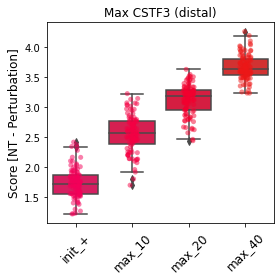

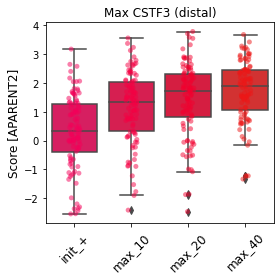

In [17]:
#Re-load, predict and visualize sequence design distributions

plot_title = "Max CSTF3 (distal)"

#Global parameters
sequence_template = 'X' * 70 + 'XXXXXX' + 'N' * 70
batch_size = 100
n_iters_per_temperature = 100

seq_start = 0
seq_end = 146

n_backgrounds = 8
min_qtl = 0.8

up_bg = ""
dn_bg = "GCATTTTTATTTTGATTTTGATGCTGATGTACCGAAGGGTTGTTTTGTGTTTACGTAGA"

#Get sequence encoder
acgt_encoder = OneHotEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})

#Experiment-specific configuration
configs = [
    {'name' : 'init_+', 'n_sequences' : 100, 'score_ix' : 2, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [4], 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_2/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_4_score_ix_2_n_sequences_100_dn_window_size_9_pos.txt'},
    
    {'name' : 'max_10', 'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_2/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_4_score_ix_2_n_sequences_100_dn_window_size_9_pos.txt', 'target_dist' : 10, 'score_ix' : 2, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [4], 'motif_blacklist_set' : 1},
    
    {'name' : 'max_20', 'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_2/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_4_score_ix_2_n_sequences_100_dn_window_size_9_pos.txt', 'target_dist' : 20, 'score_ix' : 2, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [4], 'motif_blacklist_set' : 1},
    
    {'name' : 'max_40', 'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_2/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_4_score_ix_2_n_sequences_100_dn_window_size_9_pos.txt', 'target_dist' : 40, 'score_ix' : 2, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [4], 'motif_blacklist_set' : 1},
]

names = []
x_gens = []
y_gens = []
a_gens = []

colors = ['#f40059', '#f50043', '#f3002e', '#ed1717']

for config_ix, config in enumerate(configs) :

    name = config['name']
    names.append(name)
    
    if "init_" in name :
        n_sequences = config['n_sequences']
        init_sequence_file = config['init_sequence_file']
        
        score_ix = config['score_ix']
        cell_type_1_ix = config['cell_type_1_ix']
        cell_type_2_ix = config['cell_type_2_ix']
        
        x_gen = []
        init_df = pd.read_csv(init_sequence_file, sep='\t').query("experiment == 'wt'").iloc[:n_sequences]
        for _, row in init_df.iterrows() :
            x_gen.append(
                acgt_encoder.encode(up_bg + row['seq'][:seq_end] + dn_bg)[None, None, ...]
            )

        x_gen = np.concatenate(x_gen, axis=0)[:n_sequences]
        x_gens.append(x_gen)

        ts = _predict_multi_model(tissue_models, x_gen, batch_size=32)
        y_gen = np.mean(ts[:, cell_type_1_ix, score_ix], axis=-1) - np.mean(ts[:, cell_type_2_ix, score_ix], axis=-1)
        y_gens.append(y_gen)
        
        l_gen = np.zeros((x_gen.shape[0], 13))
        l_gen[:, 11] = 1.
        d_gen = np.zeros((x_gen.shape[0], 1))
        
        a_gen = aparent.predict(x=[x_gen, l_gen, d_gen], batch_size=32)[:, 0]
        a_gens.append(a_gen)
    else :
        n_sequences = config['n_sequences']
        n_iters = config['n_iters']
        target_score = config['target_score']
        max_min = config['max_min']

        init_sequence_file = config['init_sequence_file']
        target_dist = config['target_dist']

        min_gc = config['min_gc'] if 'min_gc' in config else 0.0
        max_gc = config['max_gc'] if 'max_gc' in config else 1.0
        min_g = config['min_g'] if 'min_g' in config else 0.0
        max_g = config['max_g'] if 'max_g' in config else 1.0
        min_c = config['min_c'] if 'min_c' in config else 0.0
        max_c = config['max_c'] if 'max_c' in config else 1.0

        score_ix = config['score_ix']
        cell_type_1_ix = config['cell_type_1_ix']
        cell_type_2_ix = config['cell_type_2_ix']

        motif_blacklist_set = config['motif_blacklist_set']

        target_score_str = "target_score_" + str(target_score).replace(".", "_") if target_score is not None else max_min + "_score"
        gc_str = ("_min_gc_" + str(min_gc).replace(".", "") + "_max_gc_" + str(max_gc).replace(".", "")) if min_gc > 0.0 or max_gc < 1.0 else ""
        g_str = ("_min_g_" + str(min_g).replace(".", "") + "_max_g_" + str(max_g).replace(".", "")) if min_g > 0.0 or max_g < 1.0 else ""
        c_str = ("_min_c_" + str(min_c).replace(".", "") + "_max_c_" + str(max_c).replace(".", "")) if min_c > 0.0 or max_c < 1.0 else ""
        motif_str = "_no_motifs" if motif_blacklist_set == 1 else ("_no_motifs_strict" if motif_blacklist_set == 2 else "")

        cell_type_1_ix_str = "_and_".join([str(cell_type_1_ix[ii]) for ii in range(len(cell_type_1_ix))])
        cell_type_2_ix_str = "_and_".join([str(cell_type_2_ix[jj]) for jj in range(len(cell_type_2_ix))])

        run_prefix = "perturb_improve_" + target_score_str + gc_str + g_str + c_str + motif_str + "_" + str(n_iters) + "_iters_" + str(n_sequences) + "_seqs_" + "score_ix_" + str(score_ix) + "_ct_1_ix_" + cell_type_1_ix_str + "_ct_2_ix_" + cell_type_2_ix_str + "_target_dist_" + str(int(target_dist))

        x_gen = []
        with open('samples/' + run_prefix + '/intermediate_iter_3000.txt', 'rt') as f :

            for line in f.readlines() :
                x_gen.append(
                    acgt_encoder.encode(up_bg + line.strip() + dn_bg)[None, None, ...]
                )

        x_gen = np.concatenate(x_gen, axis=0)[:n_sequences]
        x_gens.append(x_gen)

        ts = _predict_multi_model(tissue_models, x_gen, batch_size=32)
        y_gen = np.mean(ts[:, cell_type_1_ix, score_ix], axis=-1) - np.mean(ts[:, cell_type_2_ix, score_ix], axis=-1)
        y_gens.append(y_gen)
        
        l_gen = np.zeros((x_gen.shape[0], 13))
        l_gen[:, 11] = 1.
        d_gen = np.zeros((x_gen.shape[0], 1))
        
        a_gen = aparent.predict(x=[x_gen, l_gen, d_gen], batch_size=32)[:, 0]
        a_gens.append(a_gen)

#Plot predictions
import seaborn as sns

min_y = 2.0
max_y = 6.0

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=y_gens, palette=colors)
sns.stripplot(data=y_gens, palette=colors, alpha=0.5)

plt.xticks(np.arange(len(names)), names, fontsize=12, rotation=45)
plt.ylabel("Score [NT - Perturbation]", fontsize=12)

plt.title(plot_title, fontsize=12)

#plt.ylim(min_y, max_y)

plt.tight_layout()

plt.show()

#Plot predictions (aparent2)
import seaborn as sns

min_y = 2.0
max_y = 6.0

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=a_gens, palette=colors)
sns.stripplot(data=a_gens, palette=colors, alpha=0.5)

plt.xticks(np.arange(len(names)), names, fontsize=12, rotation=45)
plt.ylabel("Score [APARENT2]", fontsize=12)

plt.title(plot_title, fontsize=12)

#plt.ylim(min_y, max_y)

plt.tight_layout()

plt.show()


--- [Experiment 0] perturb_improve_max_score_no_motifs_3000_iters_100_seqs_score_ix_0_ct_1_ix_0_ct_2_ix_4_target_dist_10 ---
--- Optimizing batch = 0 ---
Finished optimizing 100 sequences.


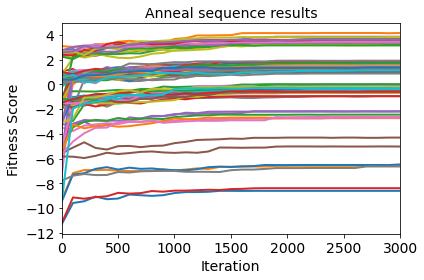

--- [Experiment 1] perturb_improve_max_score_no_motifs_3000_iters_100_seqs_score_ix_0_ct_1_ix_0_ct_2_ix_4_target_dist_20 ---
--- Optimizing batch = 0 ---
Finished optimizing 100 sequences.


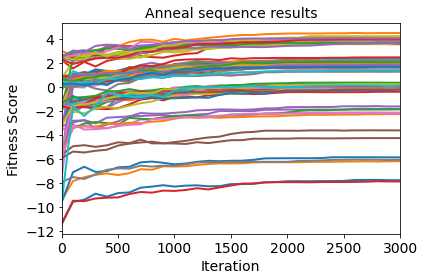

--- [Experiment 2] perturb_improve_max_score_no_motifs_3000_iters_100_seqs_score_ix_0_ct_1_ix_0_ct_2_ix_4_target_dist_40 ---
--- Optimizing batch = 0 ---
Finished optimizing 100 sequences.


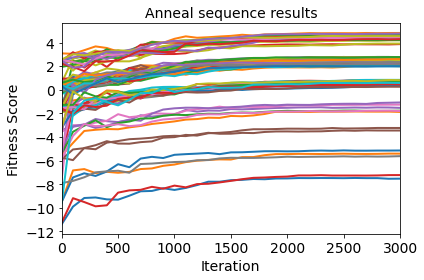

In [58]:
#Run the basinhopping algorithm (multiple conditions)

#Global parameters
sequence_template = 'X' * 70 + 'XXXXXX' + 'N' * 70
batch_size = 100
n_iters_per_temperature = 100

seq_start = 0
seq_end = 146

n_backgrounds = 8
min_qtl = 0.8

#Get sequence encoder
acgt_encoder = OneHotEncoder(seq_end - seq_start, {'A':0, 'C':1, 'G':2, 'T':3})

verbose = False

#Experiment-specific configuration
configs = [
    {'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_0/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_4_score_ix_0_n_sequences_100_dn_window_size_9_pos.txt', 'target_dist' : 10, 'score_ix' : 0, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [4], 'motif_blacklist_set' : 1},
    {'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_0/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_4_score_ix_0_n_sequences_100_dn_window_size_9_pos.txt', 'target_dist' : 20, 'score_ix' : 0, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [4], 'motif_blacklist_set' : 1},
    {'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_0/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_4_score_ix_0_n_sequences_100_dn_window_size_9_pos.txt', 'target_dist' : 40, 'score_ix' : 0, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [4], 'motif_blacklist_set' : 1},
]

for config_ix, config in enumerate(configs) :

    n_sequences = config['n_sequences']
    n_iters = config['n_iters']
    target_score = config['target_score']
    max_min = config['max_min']
    
    init_sequence_file = config['init_sequence_file']
    target_dist = config['target_dist']
    
    min_gc = config['min_gc'] if 'min_gc' in config else 0.0
    max_gc = config['max_gc'] if 'max_gc' in config else 1.0
    min_g = config['min_g'] if 'min_g' in config else 0.0
    max_g = config['max_g'] if 'max_g' in config else 1.0
    min_c = config['min_c'] if 'min_c' in config else 0.0
    max_c = config['max_c'] if 'max_c' in config else 1.0

    score_ix = config['score_ix']
    cell_type_1_ix = config['cell_type_1_ix']
    cell_type_2_ix = config['cell_type_2_ix']

    motif_blacklist_set = config['motif_blacklist_set']
    
    target_score_str = "target_score_" + str(target_score).replace(".", "_") if target_score is not None else max_min + "_score"
    gc_str = ("_min_gc_" + str(min_gc).replace(".", "") + "_max_gc_" + str(max_gc).replace(".", "")) if min_gc > 0.0 or max_gc < 1.0 else ""
    g_str = ("_min_g_" + str(min_g).replace(".", "") + "_max_g_" + str(max_g).replace(".", "")) if min_g > 0.0 or max_g < 1.0 else ""
    c_str = ("_min_c_" + str(min_c).replace(".", "") + "_max_c_" + str(max_c).replace(".", "")) if min_c > 0.0 or max_c < 1.0 else ""
    motif_str = "_no_motifs" if motif_blacklist_set == 1 else ("_no_motifs_strict" if motif_blacklist_set == 2 else "")

    cell_type_1_ix_str = "_and_".join([str(cell_type_1_ix[ii]) for ii in range(len(cell_type_1_ix))])
    cell_type_2_ix_str = "_and_".join([str(cell_type_2_ix[jj]) for jj in range(len(cell_type_2_ix))])
    
    run_prefix = "perturb_improve_" + target_score_str + gc_str + g_str + c_str + motif_str + "_" + str(n_iters) + "_iters_" + str(n_sequences) + "_seqs_" + "score_ix_" + str(score_ix) + "_ct_1_ix_" + cell_type_1_ix_str + "_ct_2_ix_" + cell_type_2_ix_str + "_target_dist_" + str(int(target_dist))

    print("--- [Experiment " + str(config_ix) + "] " + run_prefix + " ---")
    
    #Load start sequences
    init_sequences = pd.read_csv(init_sequence_file, sep='\t').query("experiment == 'wt'").iloc[:n_sequences]['seq'].str.slice(0, len(sequence_template)).values.tolist()
    
    #Generate a set of backgrounds
    flat_ts_diff = np.mean(flat_ts[:, cell_type_1_ix, score_ix], axis=-1) - np.mean(flat_ts[:, cell_type_2_ix, score_ix], axis=-1)

    keep_index = np.nonzero(flat_ts_diff >= np.quantile(flat_ts_diff, q=min_qtl))[0]

    background_index = np.random.choice(keep_index, size=(n_backgrounds,), replace=True).tolist()

    background_up = flat_x[background_index, :, :seq_start, :]
    background_dn = flat_x[background_index, :, seq_end:, :]

    #Decode and store backgrounds
    background_up_encoder = OneHotEncoder(seq_start, {'A':0, 'C':1, 'G':2, 'T':3}) if seq_start > 0 else None
    background_dn_encoder = OneHotEncoder(205 - seq_end, {'A':0, 'C':1, 'G':2, 'T':3}) if 205 - seq_end > 0 else None
    
    background_up_strs = [
        background_up_encoder.decode(background_up[bg_ix, 0, ...]) for bg_ix in range(background_up.shape[0])
    ] if background_up_encoder is not None else ["" for _ in range(background_up.shape[0])]
    
    background_dn_strs = [
        background_dn_encoder.decode(background_dn[bg_ix, 0, ...]) for bg_ix in range(background_dn.shape[0])
    ] if background_dn_encoder is not None else ["" for _ in range(background_dn.shape[0])]
    
    run_dir = "./samples/" + run_prefix + "/"
    if not os.path.exists(run_dir):
        os.makedirs(run_dir)
    
    with open(run_dir + "backgrounds_upstream.txt", "w") as f :
        for background_up_str in background_up_strs :
            f.write(background_up_str + "\n")
    
    with open(run_dir + "backgrounds_downstream.txt", "w") as f :
        for background_dn_str in background_dn_strs :
            f.write(background_dn_str + "\n")
    
    #Get templated predict function
    predict_func = get_predict_multi_model_multi_background(background_up, background_dn)
    
    t_init = 0.1
    t_func = lambda t, curr_iter, t_init=t_init, total_iters=n_iters, t_min=0.05, exp_scale=1./0.7: t_init * t_min**(min(float(curr_iter / total_iters) * exp_scale, 1.0))

    '''
    f = plt.figure(figsize=(6, 4))

    it_space = [0] + [(epoch_ix + 1) * n_iters_per_temperature for epoch_ix in range(n_iters // n_iters_per_temperature)]
    temp = t_init
    temp_space = [temp]
    for j in range(1, len(it_space)) :
        it = it_space[j]
        temp = t_func(temp, it)
        temp_space.append(temp)

    plt.plot(it_space, temp_space, linewidth=2, color='black', linestyle='-')

    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Temperature", fontsize=14)
    plt.title("Anneal schedule", fontsize=14)

    plt.xlim(0, np.max(it_space))

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()
    '''

    optimized_seqs, optimized_trajs = run_simulated_annealing_batched(n_sequences, batch_size, run_prefix, predict_func, tissue_models, score_ix, cell_type_1_ix, cell_type_2_ix, target_score, max_min, min_gc, max_gc, min_g, max_g, min_c, max_c, motif_blacklist_set, init_sequences, target_dist, sequence_template, acgt_encoder, n_iters=n_iters, n_iters_per_temperature=n_iters_per_temperature, temperature_init=t_init, temperature_func=t_func, verbose=verbose)

    print("Finished optimizing " + str(optimized_trajs.shape[0]) + " sequences.")

    plot_n_trajs = min(optimized_trajs.shape[0], 500)

    f = plt.figure(figsize=(6, 4))

    it_space = [0] + [(epoch_ix + 1) * n_iters_per_temperature for epoch_ix in range(n_iters // n_iters_per_temperature)]

    for i in range(plot_n_trajs) :
        plt.plot(it_space, optimized_trajs[i, :], linewidth=2, linestyle='-')

    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Fitness Score", fontsize=14)
    plt.title("Anneal sequence results", fontsize=14)

    plt.xlim(0, np.max(it_space))

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()


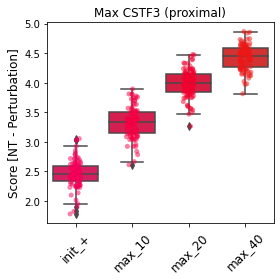

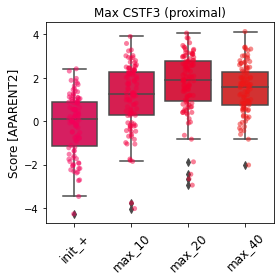

In [18]:
#Re-load, predict and visualize sequence design distributions

plot_title = "Max CSTF3 (proximal)"

#Global parameters
sequence_template = 'X' * 70 + 'XXXXXX' + 'N' * 70
batch_size = 100
n_iters_per_temperature = 100

seq_start = 0
seq_end = 146

n_backgrounds = 8
min_qtl = 0.8

up_bg = ""
dn_bg = "GCATTTTTATTTTGATTTTGATGCTGATGTACCGAAGGGTTGTTTTGTGTTTACGTAGA"

#Get sequence encoder
acgt_encoder = OneHotEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})

#Experiment-specific configuration
configs = [
    {'name' : 'init_+', 'n_sequences' : 100, 'score_ix' : 0, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [4], 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_0/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_4_score_ix_0_n_sequences_100_dn_window_size_9_pos.txt'},
    
    {'name' : 'max_10', 'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_0/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_4_score_ix_0_n_sequences_100_dn_window_size_9_pos.txt', 'target_dist' : 10, 'score_ix' : 0, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [4], 'motif_blacklist_set' : 1},
    
    {'name' : 'max_20', 'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_0/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_4_score_ix_0_n_sequences_100_dn_window_size_9_pos.txt', 'target_dist' : 20, 'score_ix' : 0, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [4], 'motif_blacklist_set' : 1},
    
    {'name' : 'max_40', 'n_sequences' : 100, 'n_iters' : 3000, 'target_score' : None, 'max_min' : 'max', 'init_sequence_file' : 'samples/unif_bg_window_size_9_score_ix_0/apa_perturb_v3_cell_type_1_ix_0_cell_type_2_ix_4_score_ix_0_n_sequences_100_dn_window_size_9_pos.txt', 'target_dist' : 40, 'score_ix' : 0, 'cell_type_1_ix' : [0], 'cell_type_2_ix' : [4], 'motif_blacklist_set' : 1},
]

names = []
x_gens = []
y_gens = []
a_gens = []

colors = ['#f40059', '#f50043', '#f3002e', '#ed1717']

for config_ix, config in enumerate(configs) :

    name = config['name']
    names.append(name)
    
    if "init_" in name :
        n_sequences = config['n_sequences']
        init_sequence_file = config['init_sequence_file']
        
        score_ix = config['score_ix']
        cell_type_1_ix = config['cell_type_1_ix']
        cell_type_2_ix = config['cell_type_2_ix']
        
        x_gen = []
        init_df = pd.read_csv(init_sequence_file, sep='\t').query("experiment == 'wt'").iloc[:n_sequences]
        for _, row in init_df.iterrows() :
            x_gen.append(
                acgt_encoder.encode(up_bg + row['seq'][:seq_end] + dn_bg)[None, None, ...]
            )

        x_gen = np.concatenate(x_gen, axis=0)[:n_sequences]
        x_gens.append(x_gen)

        ts = _predict_multi_model(tissue_models, x_gen, batch_size=32)
        y_gen = np.mean(ts[:, cell_type_1_ix, score_ix], axis=-1) - np.mean(ts[:, cell_type_2_ix, score_ix], axis=-1)
        y_gens.append(y_gen)
        
        l_gen = np.zeros((x_gen.shape[0], 13))
        l_gen[:, 11] = 1.
        d_gen = np.zeros((x_gen.shape[0], 1))
        
        a_gen = aparent.predict(x=[x_gen, l_gen, d_gen], batch_size=32)[:, 0]
        a_gens.append(a_gen)
    else :
        n_sequences = config['n_sequences']
        n_iters = config['n_iters']
        target_score = config['target_score']
        max_min = config['max_min']

        init_sequence_file = config['init_sequence_file']
        target_dist = config['target_dist']

        min_gc = config['min_gc'] if 'min_gc' in config else 0.0
        max_gc = config['max_gc'] if 'max_gc' in config else 1.0
        min_g = config['min_g'] if 'min_g' in config else 0.0
        max_g = config['max_g'] if 'max_g' in config else 1.0
        min_c = config['min_c'] if 'min_c' in config else 0.0
        max_c = config['max_c'] if 'max_c' in config else 1.0

        score_ix = config['score_ix']
        cell_type_1_ix = config['cell_type_1_ix']
        cell_type_2_ix = config['cell_type_2_ix']

        motif_blacklist_set = config['motif_blacklist_set']

        target_score_str = "target_score_" + str(target_score).replace(".", "_") if target_score is not None else max_min + "_score"
        gc_str = ("_min_gc_" + str(min_gc).replace(".", "") + "_max_gc_" + str(max_gc).replace(".", "")) if min_gc > 0.0 or max_gc < 1.0 else ""
        g_str = ("_min_g_" + str(min_g).replace(".", "") + "_max_g_" + str(max_g).replace(".", "")) if min_g > 0.0 or max_g < 1.0 else ""
        c_str = ("_min_c_" + str(min_c).replace(".", "") + "_max_c_" + str(max_c).replace(".", "")) if min_c > 0.0 or max_c < 1.0 else ""
        motif_str = "_no_motifs" if motif_blacklist_set == 1 else ("_no_motifs_strict" if motif_blacklist_set == 2 else "")

        cell_type_1_ix_str = "_and_".join([str(cell_type_1_ix[ii]) for ii in range(len(cell_type_1_ix))])
        cell_type_2_ix_str = "_and_".join([str(cell_type_2_ix[jj]) for jj in range(len(cell_type_2_ix))])

        run_prefix = "perturb_improve_" + target_score_str + gc_str + g_str + c_str + motif_str + "_" + str(n_iters) + "_iters_" + str(n_sequences) + "_seqs_" + "score_ix_" + str(score_ix) + "_ct_1_ix_" + cell_type_1_ix_str + "_ct_2_ix_" + cell_type_2_ix_str + "_target_dist_" + str(int(target_dist))

        x_gen = []
        with open('samples/' + run_prefix + '/intermediate_iter_3000.txt', 'rt') as f :

            for line in f.readlines() :
                x_gen.append(
                    acgt_encoder.encode(up_bg + line.strip() + dn_bg)[None, None, ...]
                )

        x_gen = np.concatenate(x_gen, axis=0)[:n_sequences]
        x_gens.append(x_gen)

        ts = _predict_multi_model(tissue_models, x_gen, batch_size=32)
        y_gen = np.mean(ts[:, cell_type_1_ix, score_ix], axis=-1) - np.mean(ts[:, cell_type_2_ix, score_ix], axis=-1)
        y_gens.append(y_gen)
        
        l_gen = np.zeros((x_gen.shape[0], 13))
        l_gen[:, 11] = 1.
        d_gen = np.zeros((x_gen.shape[0], 1))
        
        a_gen = aparent.predict(x=[x_gen, l_gen, d_gen], batch_size=32)[:, 0]
        a_gens.append(a_gen)

#Plot predictions
import seaborn as sns

min_y = 2.0
max_y = 6.0

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=y_gens, palette=colors)
sns.stripplot(data=y_gens, palette=colors, alpha=0.5)

plt.xticks(np.arange(len(names)), names, fontsize=12, rotation=45)
plt.ylabel("Score [NT - Perturbation]", fontsize=12)

plt.title(plot_title, fontsize=12)

#plt.ylim(min_y, max_y)

plt.tight_layout()

plt.show()

#Plot predictions (aparent2)
import seaborn as sns

min_y = 2.0
max_y = 6.0

f = plt.figure(figsize=(4, 4))

sns.boxplot(data=a_gens, palette=colors)
sns.stripplot(data=a_gens, palette=colors, alpha=0.5)

plt.xticks(np.arange(len(names)), names, fontsize=12, rotation=45)
plt.ylabel("Score [APARENT2]", fontsize=12)

plt.title(plot_title, fontsize=12)

#plt.ylim(min_y, max_y)

plt.tight_layout()

plt.show()
